In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('/Users/brandonmanley/Desktop/PhD/dijet_dsa/bmanley')
import dsa_mc.dijet_utils as dutils


In [3]:
# setup plotting
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 12
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["axes.labelsize"] = 14  
plt.rcParams["xtick.labelsize"] = 12  
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["axes.titlesize"] = 16  
plt.rcParams["text.usetex"] = True
plt.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}"

In [5]:
# initialize dijet class
dj = dutils.DijetXsec()

In [7]:
# get pT spectrum for test kinematics
pT_values = np.linspace(1,15,100)

test_kins = {'Q':7.5, 'z': 0.4, 'x': 0.01, 's': 100**2, 'delta':0.2, 'phi_Dp':0.0, 'phi_kp':0.0}
test_kins['y'] = (test_kins['Q']**2)/(test_kins['s']*test_kins['x'])

assert test_kins['y'] <= 1, 'y > 1'

test_dsa = np.array([dj.get_xsec({'pT': ipT} | test_kins, 'DSA') for ipT in pT_values])
test_total = np.array([dj.get_xsec({'pT': ipT} | test_kins, 'unpolarized') for ipT in pT_values])


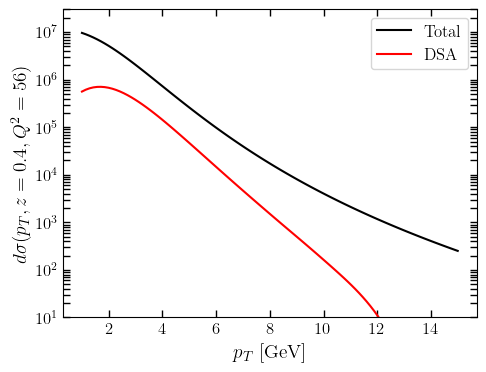

In [8]:
# plot pT spectrum
asp_ratio = 4/3
psize = 4
fig, ax = plt.subplots(1, 1, figsize=(asp_ratio*psize, psize))

ax.plot(pT_values, test_total, label = 'Total', color='black')
ax.plot(pT_values, test_dsa, label = 'DSA', color = 'red')
ax.axhline(y=0, color='grey', linestyle='--')
ax.set_xlabel(r'$p_{T}$ [GeV]')
ax.set_ylabel(fr'$d\sigma(p_T, z={test_kins['z']}, Q^2={round(test_kins['Q']**2)})$')
ax.legend()
ax.semilogy()
ax.set_ylim([10, 3*10**7])
ax.tick_params(axis="both", direction="in", length=5, width=1, which='both', right=True, top=True)

plt.show()

In [11]:
# plot the azimuthal correlations


def az_corr(kvar, kind):

    tt_term = (1+(1-kvar['y'])**2)*dj.get_coeff('A_TT_unpolar', kvar)
    ll_term = 4*(1-kvar['y'])*dj.get_coeff('A_LL_unpolar', kvar)
    denom = tt_term + ll_term 

    if kind == 'TT':
        num = 0.5*(2-kvar['y'])*(kvar['delta']/kvar['pT'])*dj.get_coeff('B_TT', kvar)
    elif kind == 'LTcoscos':
        num = 0.25*np.sqrt(2-2*kvar['y'])*(kvar['delta']/kvar['pT'])*dj.get_coeff('B_LT', kvar)
    elif kind == 'LTsinsin':
        num = 0.25*np.sqrt(2-2*kvar['y'])*(kvar['delta']/kvar['pT'])*dj.get_coeff('C_LT', kvar)
    
    return num/denom
        
test_kins['phi_kp'] = 0
test_kins['phi_Dp'] = 0
test_azcTT = np.array([az_corr({'pT': ipT} | test_kins, 'TT') for ipT in pT_values])
test_azcLTcoscos = np.array([az_corr({'pT': ipT} | test_kins, 'LTcoscos') for ipT in pT_values])

test_kins['phi_kp'] = np.pi/2
test_kins['phi_Dp'] = np.pi/2
test_azcLTsinsin = np.array([az_corr({'pT': ipT} | test_kins, 'LTsinsin') for ipT in pT_values])



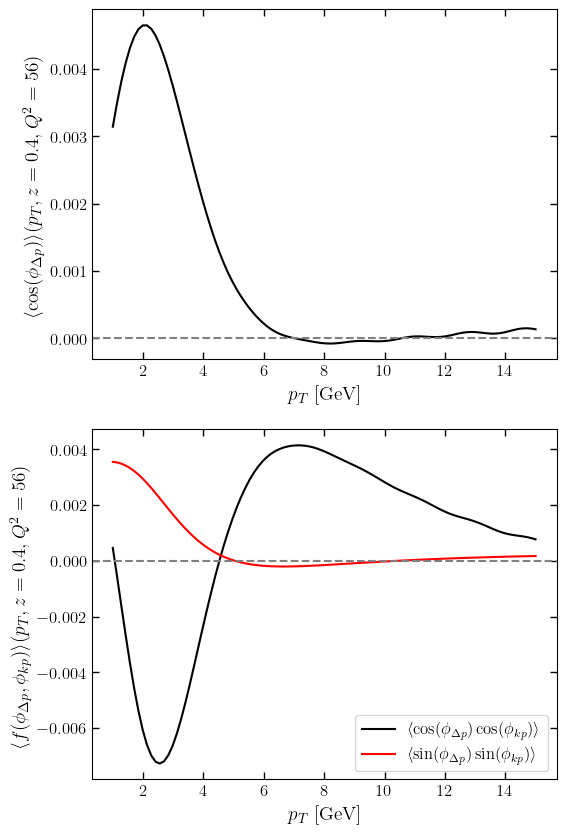

In [15]:
# plot azimuthal correlations
fig, axs = plt.subplots(2, 1, figsize=(6, 10))

axs[0].plot(pT_values, test_azcTT, color='black')
axs[0].axhline(y=0, color='grey', linestyle='--')
axs[0].set_xlabel(r'$p_{T}$ [GeV]')
axs[0].set_ylabel(fr'$ \langle \cos(\phi_{{\Delta p}}) \rangle (p_T, z={test_kins['z']}, Q^2={round(test_kins['Q']**2)})$')
axs[0].tick_params(axis="both", direction="in", length=5, width=1, which='both', right=True, top=True)
# axs[0].semilogy()
# ax.set_ylim([10, 10**8])

axs[1].plot(pT_values, test_azcLTcoscos, color='black', label=r'$\langle \cos(\phi_{\Delta p}) \cos(\phi_{k p})\rangle$')
axs[1].plot(pT_values, test_azcLTsinsin, color='red', label=r'$\langle \sin(\phi_{\Delta p}) \sin(\phi_{k p})\rangle$')
axs[1].axhline(y=0, color='grey', linestyle='--')
axs[1].set_xlabel(r'$p_{T}$ [GeV]')
axs[1].set_ylabel(fr'$ \langle f(\phi_{{\Delta p}}, \phi_{{kp}}) \rangle (p_T, z={test_kins['z']}, Q^2={round(test_kins['Q']**2)})$')
axs[1].tick_params(axis="both", direction="in", length=5, width=1, which='both', right=True, top=True)
axs[1].legend()
# axs[0].semilogy()
# ax.set_ylim([10, 10**8])

plt.show()

# fig.savefig('azcorr_ic1.pdf', dpi=400, bbox_inches="tight")


In [21]:
# compare IR regulating functions
pT_values = np.linspace(1,10,100)

zetas_g = [5, 10, 20]
zetas_s = [1, 2, 3]
cuts = [0, -1, -2]
test_r0 = 0.8

testIR_kins = {'Q':np.sqrt(5), 'z': 0.4, 'x': 0.01, 's': 100**2, 'delta':0.2, 'phi_Dp':0.0, 'phi_kp':0.0}
testIR_kins['y'] = (testIR_kins['Q']**2)/(testIR_kins['s']*testIR_kins['x'])

# double_bessel(self, kvar, indices, amp, lamIR = 0.3, IR_reg = [None, 0])

testQ_gauss = [np.array([dj.double_bessel({'pT': ipT} | testIR_kins, [0,0,0,0], 'Qu', IR_reg = ['gauss', zeta]) for ipT in pT_values]) for zeta in zetas_g]
testQ_skin = [np.array([dj.double_bessel({'pT': ipT} | testIR_kins, [0,0,0,0], 'Qu', IR_reg = ['skin', zeta, test_r0]) for ipT in pT_values]) for zeta in zetas_s]
testQ_cut = [np.array([dj.double_bessel({'pT': ipT} | testIR_kins, [0,0,0,0], 'Qu', IR_reg = ['cut', icut]) for ipT in pT_values]) for icut in cuts]



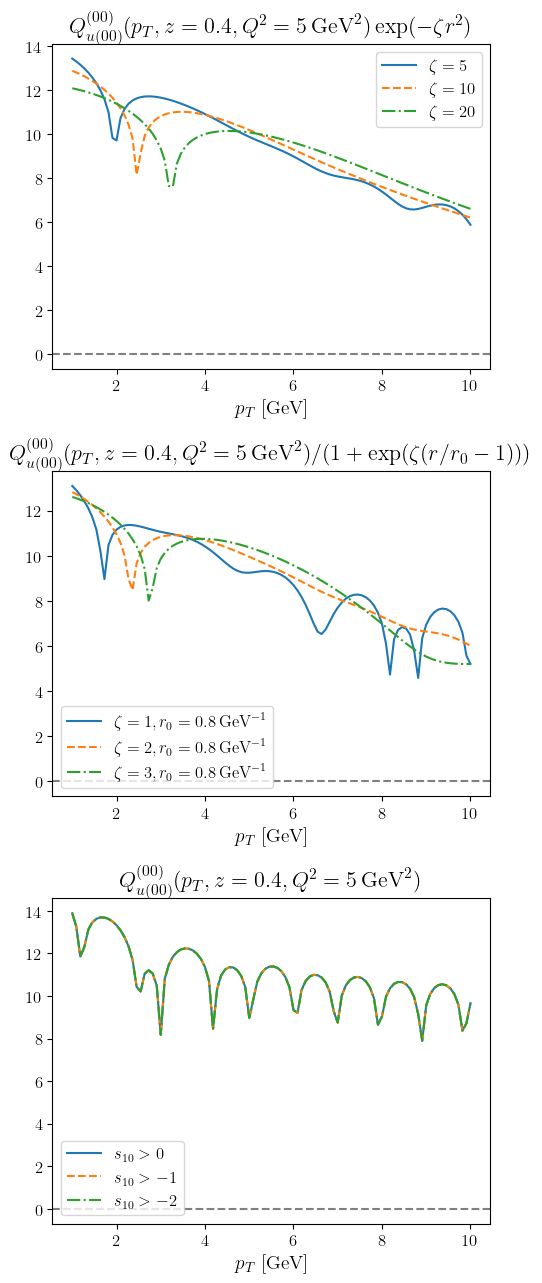

In [53]:
# IR regulator plots
fig, axes = plt.subplots(3,1, figsize=(5, 13))

lines = ['-', '--', '-.', ':']

for iz, zeta in enumerate(zetas_g):
    axes[0].plot(pT_values, np.log(np.abs(testQ_gauss[iz])), label = fr'$\zeta = {zeta}$', linestyle = lines[iz])

axes[0].axhline(y=0, color='grey', linestyle='--')
axes[0].set_xlabel(r'$p_{T}$ [GeV]')
axes[0].set_title(fr'$Q_{{u(00)}}^{{(00)}}(p_T, z={testIR_kins['z']}, Q^2={round(testIR_kins['Q']**2)}\,\mathrm{{GeV}}^2) \exp(-\zeta r^2)$')
axes[0].legend()
# axes[0].semilogy()

for iz, zeta in enumerate(zetas_s):
    axes[1].plot(pT_values, np.log(np.abs(testQ_skin[iz])), label = fr'$\zeta = {zeta}, r_0 = {test_r0}\, \mathrm{{GeV}}^{{-1}}$', linestyle = lines[iz])

axes[1].axhline(y=0, color='grey', linestyle='--')
axes[1].set_xlabel(r'$p_{T}$ [GeV]')
axes[1].set_title(fr'$Q_{{u(00)}}^{{(00)}}(p_T, z={testIR_kins['z']}, Q^2={round(testIR_kins['Q']**2)}\,\mathrm{{GeV}}^2)/(1 + \exp(\zeta (r/r_0 -1)))$')
axes[1].legend()
# axes[0].semilogy()

for ic, cut in enumerate(cuts):
    axes[2].plot(pT_values, np.log(np.abs(testQ_cut[ic])), label = fr'$s_{{10}} > {cut}$', linestyle = lines[ic])

axes[2].axhline(y=0, color='grey', linestyle='--')
axes[2].set_xlabel(r'$p_{T}$ [GeV]')
axes[2].set_title(fr'$Q_{{u(00)}}^{{(00)}}(p_T, z={testIR_kins['z']}, Q^2={round(testIR_kins['Q']**2)}\,\mathrm{{GeV}}^2)$')
axes[2].legend()
# axes[0].semilogy()

plt.tight_layout()
plt.show()


# fig.savefig(f"IR_regs{tag}.png")


